In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 16 06:42:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy import signal

In [ ]:
X_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_trainv7_multiobject_exp2_v2.npy")
X_train_f=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_f_trainv7_multiobject_exp2_v2.npy")
y_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_y_trainv7_multiobject_exp2_v2.npy").astype(int)

X_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_testv7_multiobject_exp2_v2.npy")
X_test_f=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_X_f_testv7_multiobject_exp2_v2.npy")
y_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/GraphWise_y_testv7_multiobject_exp2_v2.npy").astype(int)


In [ ]:
print(X_train.shape)
print(X_train_f.shape)
print(y_train.shape)

print(X_test.shape)
print(X_test_f.shape)
print(y_test.shape)

(875, 30, 50, 4)
(875, 30, 26, 2)
(875, 30, 30)
(125, 30, 50, 4)
(125, 30, 26, 2)
(125, 30, 30)


In [ ]:
y_train1=y_train.reshape(y_train.shape[0],-1)
y_test1=y_test.reshape(y_test.shape[0],-1)

y_train1=np.expand_dims(y_train1,-1)
y_test1=np.expand_dims(y_test1,-1)

print(y_train1.shape)
print(y_test1.shape)

(875, 900, 1)
(125, 900, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from tensorflow.keras import layers
import keras
import tensorflow as tf
padding_dim=30
padding_val=1e6

In [ ]:
!pip install keras keras_nlp
import keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 14.6 MB/s 
     |████████████████████████████████| 4.6 MB 69.9 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 511.7 MB 4.6 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.9 MB 53.1 MB/s 


In [ ]:
padding_val=1e6

class out_adj_mat(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(out_adj_mat, self).__init__(**kwargs)

    def call(self, inputs):
        out1=tf.matmul(inputs,tf.transpose(inputs,[0,2,1]))#Loss
        out2=tf.keras.layers.Activation('sigmoid')(out1)#Actual output
        out1=tf.reshape(out1,(-1,padding_dim*padding_dim))
        out1=tf.expand_dims(out1,-1)
        return out1
    
    def compute_mask(self, inputs, mask=None):
        mask=tf.expand_dims(mask,axis=-1)
        mask=tf.cast(mask,tf.dtypes.int64)
        mask2=tf.matmul(mask,tf.transpose(mask,[0,2,1]))#Actual Output
        mask1=tf.experimental.numpy.triu(mask2,1)#Loss
        mask1=tf.cast(mask1,bool)
        mask1=tf.reshape(mask1,(-1,padding_dim*padding_dim))
        return mask1


# Part 2 - Building the RNN

# Importing the Keras libraries and packages

input_1 = Input((X_train.shape[1], X_train.shape[2], X_train.shape[3]),name="time") #20,50,4
input_2 = Input((X_train_f.shape[1], X_train_f.shape[2], X_train_f.shape[3]),name="freq") #20,26,2

x1=layers.Masking(mask_value=padding_val)(input_1)
x1=layers.TimeDistributed(LSTM(units = 100, return_sequences = True))(x1)
x1=layers.TimeDistributed(LSTM(units = 50))(x1)

x2=layers.Masking(mask_value=padding_val)(input_2)
x2=layers.TimeDistributed(LSTM(units = 100, return_sequences = True))(x2)
x2=layers.TimeDistributed(LSTM(units = 50))(x2)

merge_layer=layers.concatenate([x1,x2]) #B,20,100
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(merge_layer)
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(x)
x=keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1)(x)

out=out_adj_mat()(x)

classifier=keras.Model(inputs=[input_1, input_2], outputs=[out])

# # Compiling the RNN
classifier.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = 'accuracy')


In [ ]:
print(x1._keras_mask)
print(x2._keras_mask)
print(merge_layer._keras_mask)
print(x._keras_mask)
print(out._keras_mask)
# print(A_rec._keras_mask)

print(out)
# print(A_rec)

print(x)
print(tf.transpose(x,[0,2,1]))

KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.bool, name=None), name='Any:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.bool, name=None), name='Any:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.bool, name=None), name='All:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.bool, name=None), name='Placeholder_1:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 900), dtype=tf.bool, name=None), name='Reshape:0')
KerasTensor(type_spec=TensorSpec(shape=(None, 900, 1), dtype=tf.float32, name=None), name='out_adj_mat/ExpandDims:0', description="created by layer 'out_adj_mat'")
KerasTensor(type_spec=TensorSpec(shape=(None, 30, 100), dtype=tf.float32, name=None), name='transformer_encoder_2/layer_normalization_1/batchnorm/add_1:0', description="created by layer 'transformer_encoder_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 30), dtype=tf.float32, name=None), name='tf.compat.v1.transpose/transpose:0', description="created

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_multiobject_exp2_v2.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 50, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop,checkpoint]


In [ ]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time (InputLayer)              [(None, 30, 50, 4)]  0           []                               
                                                                                                  
 freq (InputLayer)              [(None, 30, 26, 2)]  0           []                               
                                                                                                  
 masking (Masking)              (None, 30, 50, 4)    0           ['time[0][0]']                   
                                                                                                  
 masking_1 (Masking)            (None, 30, 26, 2)    0           ['freq[0][0]']                   
                                                                                              

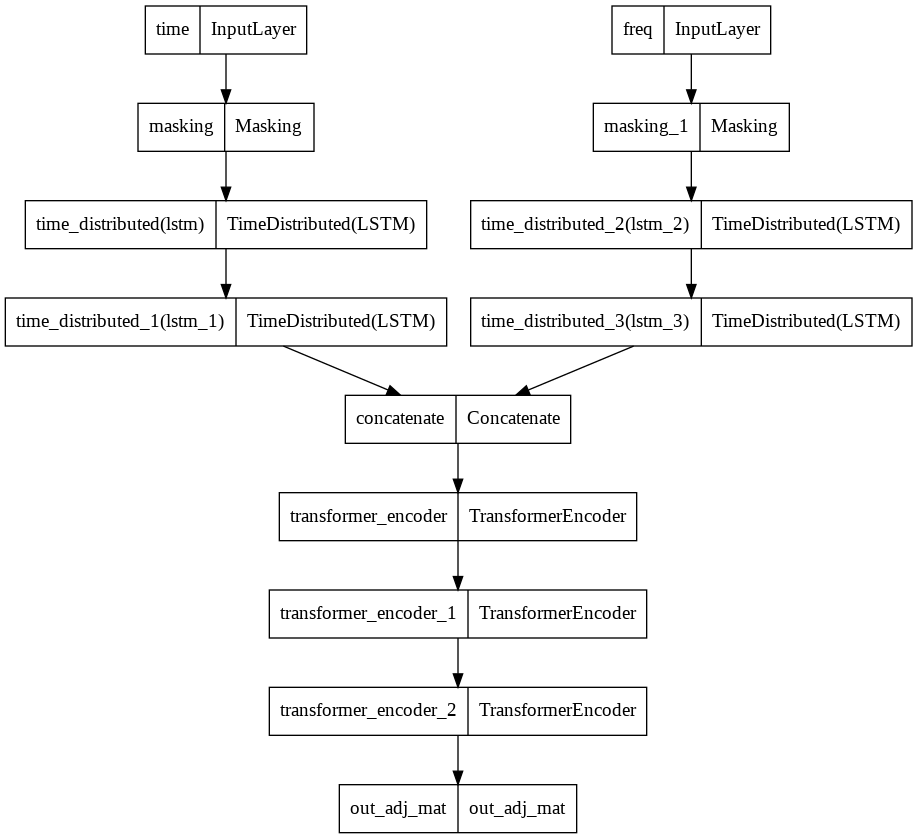

In [ ]:
tf.keras.utils.plot_model(classifier)

In [ ]:
# Fitting the RNN to the Training set
history=classifier.fit([X_train,X_train_f], y_train1, epochs = 500, batch_size = 64,validation_data=([X_test,X_test_f],y_test1),callbacks=callbacks)


Epoch 1/500
14/14 [==============================] - ETA: 0s - loss: 3.3830 - accuracy: 0.4265
Epoch 1: val_accuracy improved from -inf to 0.61340, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_multiobject_exp2_v2.h5
14/14 [==============================] - 46s 758ms/step - loss: 3.3830 - accuracy: 0.4265 - val_loss: 6.8723 - val_accuracy: 0.6134
Epoch 2/500


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


14/14 [==============================] - ETA: 0s - loss: 0.8737 - accuracy: 0.5324
Epoch 2: val_accuracy did not improve from 0.61340
14/14 [==============================] - 5s 344ms/step - loss: 0.8737 - accuracy: 0.5324 - val_loss: 8.0013 - val_accuracy: 0.4234
Epoch 3/500
14/14 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.5046
Epoch 3: val_accuracy did not improve from 0.61340
14/14 [==============================] - 5s 348ms/step - loss: 0.6002 - accuracy: 0.5046 - val_loss: 8.9536 - val_accuracy: 0.3008
Epoch 4/500
14/14 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.5288
Epoch 4: val_accuracy did not improve from 0.61340
14/14 [==============================] - 5s 350ms/step - loss: 0.5363 - accuracy: 0.5288 - val_loss: 7.9665 - val_accuracy: 0.4208
Epoch 5/500
14/14 [==============================] - ETA: 0s - loss: 0.4876 - accuracy: 0.5448
Epoch 5: val_accuracy did not improve from 0.61340
14/14 [============================

In [ ]:
classifier.evaluate([X_test,X_test_f],y_test1)

4/4 [==============================] - 0s 47ms/step - loss: 0.0791 - accuracy: 0.9420


[0.07911816239356995, 0.941962718963623]

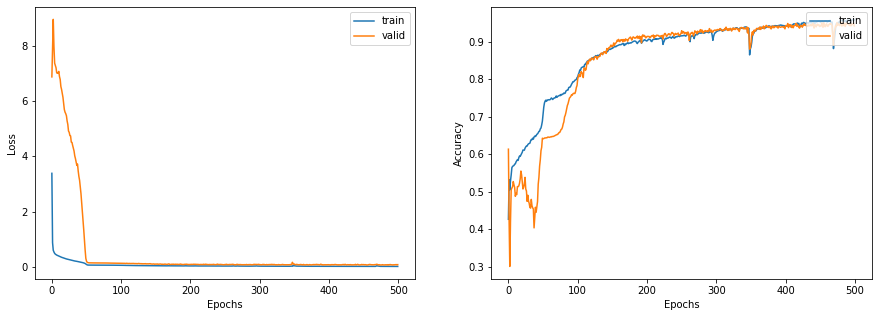

In [ ]:
import matplotlib.pyplot as plt
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

display_learning_curves(history)

In [ ]:
import tensorflow as tf
temp=tf.keras.models.load_model("./drive/MyDrive/MSc Thesis/Experiments/models/Transformer_1d_freq_multiobject_exp2_v2.h5",
                                custom_objects={'TransformerEncoder': keras_nlp.layers.TransformerEncoder(intermediate_dim=64, num_heads=4,dropout=0.1),
                                                'out_adj_mat':out_adj_mat()})

In [ ]:
temp.evaluate([X_test,X_test_f], y_test1, 1)

125/125 [==============================] - 22s 64ms/step - loss: 0.0684 - accuracy: 0.9516


[0.06835634261369705, 0.9516212344169617]

In [ ]:
from tqdm.notebook import tqdm
true=[]
pred=[]
for i in tqdm(range(len(y_test1))):
  result=temp([X_test[i:i+1],X_test_f[i:i+1]])
  true=true+list(y_test1[i,:,0][result._keras_mask[0,:]])
  temp_pred=np.array(result[result._keras_mask][:,0])
  temp_pred[temp_pred>=0]=1
  temp_pred[temp_pred<0]=0
  pred=pred+list(temp_pred)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [ ]:
confusion_matrix(true,pred)

array([[19303,  1209],
       [   52,  2628]])

In [ ]:
accuracy_score(true,pred)

0.945627802690583

In [ ]:
f1_score(true,pred)

0.806506061071045

In [ ]:
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     20512
           1       0.68      0.98      0.81      2680

    accuracy                           0.95     23192
   macro avg       0.84      0.96      0.89     23192
weighted avg       0.96      0.95      0.95     23192



In [ ]:
##inter structure FP vs intra structure FP rate

In [ ]:
def create_obj_ind(arr):
  temp_adj_mat=copy.copy(arr)
  index=np.where(temp_adj_mat[0,:]==1e6)[0]
  if(len(index)==0):
    index=temp_adj_mat.shape[0]
  else:
    index=index[0]
  temp_adj_mat1=temp_adj_mat[:index,:index]
  n1=np.where(np.sum(temp_adj_mat1,axis=0)==0)[0][1]
  temp_adj_mat[:n1,n1:index]=-1
  temp_adj_mat[n1:index,:n1]=-1
  return(temp_adj_mat)

In [ ]:
obj_ind_test=[]
for i in range(y_test.shape[0]):
  obj_ind_test.append(create_obj_ind(y_test[i]))
obj_ind_test=np.stack(obj_ind_test)

In [ ]:
obj_ind_test.shape

(125, 30, 30)

In [ ]:
obj_ind_test1=obj_ind_test.reshape(obj_ind_test.shape[0],-1)
obj_ind_test1=np.expand_dims(obj_ind_test1,-1)
obj_ind_test1.shape

(125, 900, 1)

In [ ]:
from tqdm.notebook import tqdm
obj_ind_test_list=[]
for i in tqdm(range(len(y_test1))):
  result=temp([X_test[i:i+1],X_test_f[i:i+1]])
  obj_ind_test_list=obj_ind_test_list+list(obj_ind_test1[i,:,0][result._keras_mask[0,:]])
  

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
print(len(true))
print(len(obj_ind_test_list))

23192
23192


In [ ]:
prediction=pd.DataFrame({'true':true,'pred':np.array(pred).astype(int),'obj_ind':obj_ind_test_list})
prediction

,true,pred,obj_ind
0,1,1,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
23187,0,0,0
23188,0,0,0
23189,0,0,0
23190,0,0,0


In [ ]:
prediction.loc[(prediction['true']==0) & (prediction['pred']==1) & (prediction['obj_ind']==-1)]

,true,pred,obj_ind
773,0,1,-1
6002,0,1,-1
14158,0,1,-1
17608,0,1,-1
18101,0,1,-1


In [ ]:
#inter, intra structure positive rate
inter_structure_FP=prediction.loc[(prediction['true']==0) & (prediction['pred']==1) & (prediction['obj_ind']==-1)]
intra_structure_FP=prediction.loc[(prediction['true']==0) & (prediction['pred']==1) & (prediction['obj_ind']!=-1)]
FP=prediction.loc[(prediction['true']==0) & (prediction['pred']==1)]

In [ ]:
inter_structure_FP.shape[0]/FP.shape[0]*100

0.41356492969396197

In [ ]:
intra_structure_FP.shape[0]/FP.shape[0]*100

99.58643507030604

In [ ]:
def create_pairs(arr,c):  
    l=np.empty((0,4))
    for i in range(arr.shape[0]):
        for j in range(i+1,arr.shape[0]):
            l=np.vstack([l,np.array([c,i,j,arr[i,j]])])
    return(l)

In [ ]:
pair_preds=np.empty((0,4))
pair_true=np.empty((0,4))
for i in tqdm(range(len(y_test))):
  temp_adj_mat=copy.copy(y_test[i])
  index=index=np.where(temp_adj_mat[0,:]==1e6)[0][0]
  temp_adj_mat=temp_adj_mat[:index,:index]
  pair_true=np.vstack([pair_true,create_pairs(temp_adj_mat,i+250)])

  result=temp([X_test[i:i+1],X_test_f[i:i+1]])
  temp_result=result[0].numpy().reshape(30,30)[:index,:index]
  temp_result[temp_result>=0]=1
  temp_result[temp_result<0]=0
  temp_result=np.triu(temp_result,1)
  pair_preds=np.vstack([pair_preds,create_pairs(temp_result,i+250)])



  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
f1_score(pair_true[:,-1],pair_preds[:,-1])

0.806506061071045

In [ ]:
pair_preds=pd.DataFrame(pair_preds)
pair_preds.columns=['video_id','n1','n2','pred_edge']
pair_true=pd.DataFrame(pair_true)
pair_true.columns=['video_id','n1','n2','true_edge']

In [ ]:
predictions=pd.concat([pair_preds,pair_true['true_edge']],axis=1)
predictions

,video_id,n1,n2,pred_edge,true_edge
0,250.0,0.0,1.0,1.0,1.0
1,250.0,0.0,2.0,0.0,0.0
2,250.0,0.0,3.0,0.0,0.0
3,250.0,0.0,4.0,0.0,0.0
4,250.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...
23187,374.0,15.0,17.0,0.0,0.0
23188,374.0,15.0,18.0,0.0,0.0
23189,374.0,16.0,17.0,0.0,0.0
23190,374.0,16.0,18.0,0.0,0.0


In [ ]:
predictions.to_excel('Multiple_Object_Transformer_1d_freq_exp2.xlsx',index=False)